In [106]:
import sys
sys.path.append('../')
from icaviz.plotting import *
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib import cm
import matplotlib

from pymodulon.core import *
from pymodulon.plotting import *
from pymodulon.compare import *
from pymodulon.io import *


pd.options.display.max_columns = 999 

In [2]:
#format figures
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Also, if you want your axes lines to be true black, and not this weird dark gray:
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['ytick.color'] = 'black'

In [3]:
DATA_DIR = '../data/precise2/'
PRECISE_DIR = '../data/precise/'
GENE_DIR = '../data/annotation/'
gene_info = pd.read_csv(GENE_DIR+'gene_info.csv', index_col =0)

In [4]:
ica_data = load_json_model(DATA_DIR+'precise2.json.gz')

# Figure 4- YgeV

In [5]:
def plot_gene_weights_edit(
    ica_data: IcaData,
    imodulon: ImodName,
    xaxis=None,
    xname="",
    by: Optional[str] = "start",
    ref_cols: Optional[SeqSetStr] = None,
    **kwargs,
) -> Ax:
    """
    Generates a scatter-plot, with gene weights on the y-axis, and either
    the mean expression, gene length, or gene start site on the x-axis.
    Also shows the D'Agostino cutoff. Labels the statistically
    enriched genes, if the appropriate parameters are given.

    Parameters
    ----------
    ica_data: pymodulon.core.IcaData
        IcaData container object
    imodulon: int, str
        The name of the iModulon to plot
    xaxis:
        Experimental parameter. See `_set_axis()` for further details.
    xname:
        Experimental parameter. See `_set_axis()` for further details.
    by: 'log-tpm-norm', 'length', 'start'
        Gene property to plot on the x-axis. log-tpm-norm plots mean
        expression, length plots gene length, and start plots gene start
        position
    ref_cols: Sequence, set, or str
        A str or list of str values to use for normalizing the log-tpm data.
        Only used if 'log-tpm-norm' is given for the `by` parameter.
    **kwargs: dict
        keyword arguments passed onto `scatterplot()`

    Returns
    -------
    ax: matplotlib.axes instance
        Returns the axes instance on which the scatter-plot is generated
    """
    # Check that iModulon exists
    if imodulon in ica_data.M.columns:
        y = ica_data.M[imodulon]
        ylabel = f"{imodulon} Gene Weight"
    else:
        raise ValueError(f"iModulon does not exist: {imodulon}")

    # Get genes in the iModulon
    bin_M = ica_data.M_binarized
    component_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 1].index)
    other_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 0].index)

    # If experimental `xaxis` parameter is used, use custom values for x-axis
    if xaxis is not None:
        x = _set_xaxis(xaxis=xaxis, y=y)
        xlabel = xname

    else:
        #  Ensure 'by' has a valid input and assign x, xlabel accordingly
        if by in ("log-tpm", "log-tpm-norm"):
            x = _normalize_expr(ica_data, ref_cols)
            xlabel = "Mean Expression"
        elif by == "length":
            x = np.log10(ica_data.gene_table.length)
            xlabel = "Gene Length (log10-scale)"
        elif by == "start":
            x = ica_data.gene_table.start
            xlabel = "Gene Start"
        else:
            raise ValueError('"by" must be "log-tpm-norm", "length", ' 'or "start"')

    # Override specific kwargs (their implementation is different
    # in this function)
    show_labels_pgw = kwargs.pop("show_labels", "auto")
    adjust_labels_pgw = kwargs.pop("adjust_labels", True)
    legend_kwargs_pgw = kwargs.pop("legend_kwargs", {})

    kwargs["show_labels"] = kwargs["adjust_labels"] = False

    # Remove xlabel and ylabel kwargs if provided
    kwargs.pop("xlabel", None)
    kwargs.pop("ylabel", None)

    # Default legend should be on the side of the plot
    if (
        "bbox_to_anchor" not in legend_kwargs_pgw.keys()
        and "loc" not in legend_kwargs_pgw.keys()
    ):
        legend_kwargs_pgw.update({"bbox_to_anchor": (1, 1), "loc": 2})
        kwargs["legend_kwargs"] = legend_kwargs_pgw

    # Update colors for COG groups
    if "COG" in ica_data.gene_table.columns and "groups" not in kwargs:
        mod_cogs = ica_data.gene_table.loc[component_genes].COG
        hidden_cogs = pd.Series("hidden", index=other_genes)
        all_cogs = pd.concat([mod_cogs, hidden_cogs])
        # colors = {cog:ica_data.cog_colors[cog] for cog in sorted(mod_cogs.unique())}
        kwargs.update({"groups": all_cogs, "colors": ica_data.cog_colors})

    # Scatter Plot
    ax = scatterplot(x, y, xlabel=xlabel, ylabel=ylabel, **kwargs)

    # Add thresholds to scatter-plot (dashed lines)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    thresh = ica_data.thresholds[imodulon]
    if thresh != 0:
        ax.hlines(
            [thresh, -thresh],
            xmin=xmin,
            xmax=xmax,
            colors="k",
            linestyles="dashed",
            linewidth=1,
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    texts = []
    expand_kwargs = {"expand_objects": (1.2, 1.4), "expand_points": (1.3, 1.3)}

    # Add labels: Put gene name if components contain under 20 genes
    if show_labels_pgw is True or (
        show_labels_pgw is not False and len(component_genes) <= 20
    ):
        for gene in component_genes:
            texts.append(
                ax.text(
                    x[gene],
                    ica_data.M.loc[gene, imodulon],
                    ica_data.gene_table.loc[gene, "gene_name"],
                    fontsize=9,
                )
            )

        expand_kwargs["expand_text"] = (1.4, 1.5)

    # Add labels: Repel texts from other text and points
    rect = ax.add_patch(
        Rectangle(
            xy=(xmin, -abs(thresh)),
            width=xmax - xmin,
            height=2 * abs(thresh),
            fill=False,
            linewidth=0,
        )
    )

    if adjust_labels_pgw:
        adjust_text(
            texts=texts,
            add_objects=[rect],
            ax=ax,
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            only_move={"objects": "y"},
            **expand_kwargs,
        )

    return ax

In [6]:
import seaborn as sns
sns.set_style('ticks')

In [7]:
ica_data.gene_table.COG.unique()

array(['Amino acid transport and metabolism',
       'Nucleotide transport and metabolism', 'Function unknown',
       'Carbohydrate transport and metabolism', 'No COG annotation',
       'Post-translational modification, protein turnover,and chaperones',
       'Replication, recombination and repair',
       'Inorganic ion transport and metabolism', 'Transcription',
       'Translation, ribosomal structure and biogenesis',
       'Coenzyme transport and metabolism',
       'Cell wall/membrane/envelope biogenesis',
       'Lipid transport and metabolism',
       'Energy production and conversion',
       'Signal transduction mechanisms',
       'Cell cycle control, cell division, chromosome partitioning',
       'Intracellular trafficking, secretion, and vesicular transport',
       'Cell motility', 'Defense mechanisms',
       'Secondary metabolites biosynthesis, transport, and catabolism',
       'RNA processing and modification'], dtype=object)

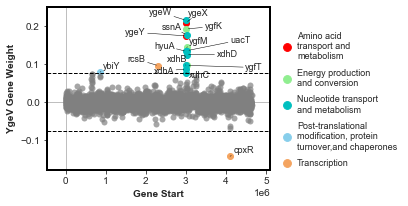

In [8]:
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig,ax = plt.subplots(figsize=(4,3))

plot_gene_weights_edit(ica_data,'YgeV', ax=ax)

ax.spines['top'].set_color('0'); ax.spines['bottom'].set_color('0')
ax.spines['left'].set_color('0'); ax.spines['right'].set_color('0')

ax.spines['top'].set_linewidth(2); ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2); ax.spines['right'].set_linewidth(2)
ax.grid(False)

ax.set_ylabel('YgeV Gene Weight',fontsize=10, fontweight ='bold')
ax.set_xlabel('Gene Start',fontsize=10, fontweight ='bold')

labels = ['','Amino acid\ntransport and\nmetabolism', 'Energy production\nand conversion',
         'Nucleotide transport\nand metabolism', 
         'Post-translational\nmodification, protein\nturnover,and chaperones',
         'Transcription']

plt.legend(labels=labels,bbox_to_anchor=(1,1),fontsize=9,ncol=1, markerscale=1.3, handletextpad=.1,
          frameon=False, labelspacing=.8)

plt.savefig('./fig4/YgeV_genes.pdf', dpi = 600, bbox_inches = 'tight')

<AxesSubplot:ylabel='YgeV iModulon\nActivity'>

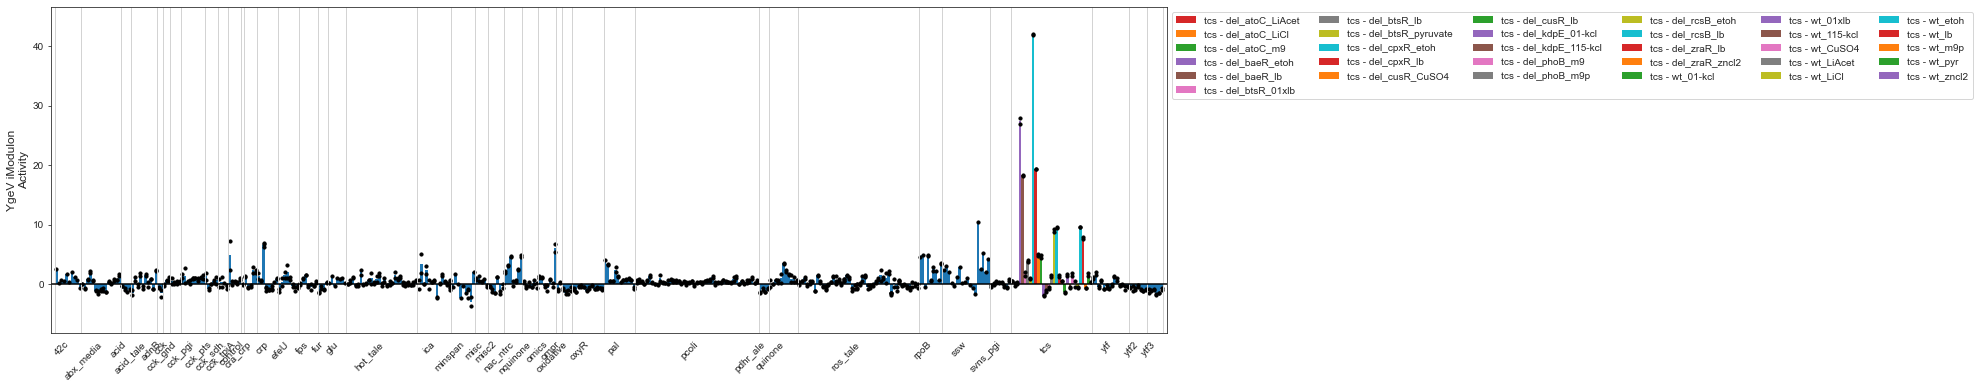

In [9]:
_, ax = plt.subplots(figsize=(20, 6))
plot_activities(ica_data,'YgeV', highlight='tcs', ax=ax)

In [10]:
ygeV_A_df = ica_data.A[ica_data.A.index == 'YgeV']
ygeV_A_df.columns = ica_data.sample_table.full_name

ygeV_A_df

full_name,control:wt_glc,control:wt_glc,fur:wt_dpd,fur:wt_dpd,fur:wt_fe,fur:wt_fe,fur:delfur_dpd,fur:delfur_dpd,fur:delfur_fe2,fur:delfur_fe2,acid:wt_ph5,acid:wt_ph5,acid:delgadx_ph5,acid:delgadw_ph5,acid:delgadw_ph5,acid:delgade_ph5,acid:delgade_ph5,oxidative:wt_pq,oxidative:wt_pq,oxidative:deloxyr_pq,oxidative:deloxyr_pq,oxidative:delsoxr_pq,oxidative:delsoxr_pq,oxidative:delsoxs_pq,oxidative:delsoxs_pq,nac_ntrc:wt_csn,nac_ntrc:wt_csn,nac_ntrc:wt_cytd,nac_ntrc:wt_cytd,nac_ntrc:wt_gln,nac_ntrc:wt_gln,nac_ntrc:bw_delnac_csn,nac_ntrc:bw_delnac_csn,nac_ntrc:bw_delnac_cytd,nac_ntrc:bw_delnac_cytd,nac_ntrc:bw_delnac_gln,nac_ntrc:bw_delnac_gln,nac_ntrc:bw_delnac_nh4,nac_ntrc:bw_delnac_nh4,misc:wt_no_te,misc:wt_no_te,misc:bw_delcbl,misc:bw_delcbl,misc:bw_delfabr,misc:bw_delfabr,misc:bw_delfadr,misc:bw_delfadr,misc:nitr_031,omics:wt_glu,omics:wt_glu,omics:wt_gly,omics:wt_gly,omics:wt_thr,omics:wt_thr,omics:bw_ac,omics:bw_ac,omics:bw_fum,omics:bw_fum,omics:bw_glc,omics:bw_glc,omics:bw_pyr,omics:bw_pyr,ompr:wt_nacl,ompr:wt_nacl,ompr:bw_delompr_nacl,ompr:bw_delompr_nacl,minspan:wt_ade,minspan:wt_glc,minspan:wt_glc,minspan:wt_glc,minspan:wt_glc_anaero,minspan:wt_glc_anaero,minspan:wt_trp,minspan:bw_delcra_glc,minspan:bw_delcra_trp,minspan:bw_delmntr,minspan:bw_delnac_ade,minspan:bw_delnac_glc,cra_crp:wt_ac,cra_crp:wt_ac,cra_crp:wt_fru,cra_crp:wt_fru,cra_crp:delcra_ac,cra_crp:delcra_ac,cra_crp:delcra_fru,cra_crp:delcra_fru,cra_crp:delcra_glc,cra_crp:delcra_glc,rpoB:wt_031,rpoB:wt_044,rpoB:wt_lb,rpoB:wt_lb,rpoB:rpoBE546V_031,rpoB:rpoBE546V_044,rpoB:rpoBE546V_lb,rpoB:rpoBE546V_lb,rpoB:rpoBE546V_glc,rpoB:rpoBE672K_glc,rpoB:rpoBE672K_glc,rpoB:rpoBE672K_lb,rpoB:rpoBE672K_lb,crp:wt_fru,crp:wt_glyc,crp:wt_glyc,crp:delar1_glyc,crp:delar1_glyc,crp:delar1ar2_glyc,crp:delar1ar2_glyc,crp:delar1ar2_glyc,crp:delar2_glyc,crp:delar2_glyc,crp:delar2_glyc,crp:delcrp_fru,crp:delcrp_fru,crp:delcrp_fru,crp:delcrp_glc,crp:delcrp_glc,crp:delcrp_glc,crp:delcrp_glyc,crp:delcrp_glyc,crp:delcrp_glyc,glu:glu_ale3,glu:glu_ale4,glu:glu_ale5,glu:glu_ale6,glu:glu_ale8,glu:glu_ale9,glu:glu_ale10,42c:wt_42c,42c:42c_ale1,42c:42c_ale2,42c:42c_ale3,42c:42c_ale4,42c:42c_ale5,42c:42c_ale6,42c:42c_ale8,42c:42c_ale9,42c:42c_ale10,ssw:wt_ac,ssw:wt_glc,ssw:wt_glyc,ssw:wt_xyl,ssw:glc_ale1,ssw:glc_ale2,ssw:glc_ale3,ssw:glyc_ale1,ssw:glyc_ale2,ssw:xyl_ale1,ssw:xyl_ale2,ssw:xyl_ale3,ssw:glc_ac_ac2,ssw:glc_ac_glc1,ssw:glc_glyc_glc,ssw:glc_glyc_glyc,ssw:glc_xyl_glc,ssw:glc_xyl_xyl,ica:wt_glc,ica:wt_glc,ica:wt_glc,ica:wt_glc,ica:arg_sbt,ica:arg_sbt,ica:cytd_rib,ica:cytd_rib,ica:gth,ica:gth,ica:leu_glcr,ica:leu_glcr,ica:met_glc,ica:met_glc,ica:no3_anaero,ica:no3_anaero,ica:phe_acgam,ica:phe_acgam,ica:thm_gal,ica:thm_gal,ica:tyr_glcn,ica:tyr_glcn,ica:ura_pyr,ica:ura_pyr,ica:wt_glc,ica:wt_glc,ica:bw_delpurR_cytd,ica:bw_delpurR_cytd,ica:ade_glc,ica:ade_glc,ytf:wt_glc,ytf:wt_glc,ytf:delyafC,ytf:delyafC,ytf:delyeiE,ytf:delyeiE,ytf:delyiaJ,ytf:delyiaJ,ytf:delyieP,ytf:delyieP,ytf:wt_ph5,ytf:wt_ph5,ytf:wt_ph8,ytf:wt_ph8,ytf:delybaO,ytf:delybaO,ytf:delybaQ,ytf:delybaQ,ytf:delybiH,ytf:delybiH,ytf:delydcI_ph5,ytf:delydcI_ph5,ytf:delydcI_ph8,ytf:delydcI_ph8,ytf:delyddM,ytf:delyddM,ytf:delyheO,ytf:delyheO,fps:bw_glc,fps:bw_glc,fps:fps_thrA_ale1,fps:fps_thrA_ale1,fps:fps_thrA_ale2,fps:fps_thrA_ale2,fps:fps_serB_ale1,fps:fps_serB_ale1,fps:fps_serB_ale4,fps:fps_serB_ale4,fps:fps_ptsI_ale1,fps:fps_ptsI_ale1,fps:fps_ptsI_ale3,fps:fps_ptsI_ale3,pal:lyx_ale2_f6,pal:lyx_ale2,pal:lyx_ale2,pal:lyx_ale4,pal:lyx_ale4,pal:5drib_ale10_f18,pal:5drib_ale10_f18,pal:5drib_ale10,pal:arab_ale14_f9,pal:arab_ale14_f9,pal:arab_ale14,pal:arab_ale14,pal:arab_ale16,pal:arab_ale16,pal:tartr_ale26_f10,pal:tartr_ale26_f10,pal:tartr_ale26,pal:tartr_ale26,pal:tartr_ale28_f10,pal:tartr_ale28_f10,pal:tartr_ale28,pal:tartr_ale28,efeU:delmenFentC_citr,efeU:delmenFentC_citr,efeU:delmenFentC,efeU:delmenFentC,efeU:menFentC_ale39,efeU:menFentC_ale39,efeU:menFentC_ale29,efeU:menFentC_ale29,efeU:menFentC_ale30,efeU:menFentC_ale30,efeU:menFen

In [11]:
conditions = ['tcs:del_baeR_lb', 'tcs:del_baeR_etoh', 'tcs:del_cpxR_lb', 'tcs:del_cpxR_etoh',
             'tcs:wt_lb', 'tcs:wt_etoh']

ygeV_A_TCS_df = ygeV_A_df[conditions].T

ygeV_A_TCS_df

,YgeV
full_name,
tcs:del_baeR_lb,18.380461
tcs:del_baeR_lb,18.224468
tcs:del_baeR_etoh,26.863374
tcs:del_baeR_etoh,27.930796
tcs:del_cpxR_lb,19.402058
tcs:del_cpxR_lb,19.366672
tcs:del_cpxR_etoh,42.034525
tcs:del_cpxR_etoh,41.831962
tcs:wt_lb,7.897908


In [12]:
ygeV_pivot = ygeV_A_TCS_df.reset_index().pivot_table(columns=["full_name"])[conditions].T

ygeV_pivot

,YgeV
full_name,
tcs:del_baeR_lb,18.302464
tcs:del_baeR_etoh,27.397085
tcs:del_cpxR_lb,19.384365
tcs:del_cpxR_etoh,41.933244
tcs:wt_lb,7.762221
tcs:wt_etoh,9.612084


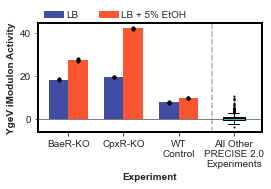

In [13]:
fig, ax1 = plt.subplots(figsize=(4,2))

# bar plot
labels = ['BaeR-KO', 'CpxR-KO', 'WT\nControl', 'All Other\nPRECISE 2.0\nExperiments']
LB = ygeV_pivot[ygeV_pivot.index.str.contains('_lb')].YgeV.to_list()+[0]
Ethanol = ygeV_pivot[ygeV_pivot.index.str.contains('_etoh')].YgeV.to_list()+[0]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax1.bar(x - width/2, LB, width, label='LB', lw=0, color='#3F4EA2')
rects2 = ax1.bar(x + width/2, Ethanol, width, label='LB + 5% EtOH', lw=0, color = '#FA5631')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('YgeV iModulon Activity', fontsize=10, fontweight='bold')
ax1.set_xlabel('Experiment', fontsize=10, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(bbox_to_anchor=(0.7,1.2), frameon=False, ncol=2, 
           columnspacing=2, handletextpad=.2)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        
autolabel(rects1)
autolabel(rects2)

#scatterpoints
scatter_x = []
for i in x[:-1]:
    scatter_x.extend([i-width/2]*2+ [i+width/2]*2)
ax1.scatter(scatter_x, ygeV_A_TCS_df.YgeV, color="k", zorder=2, s=10)


# boxplot
ax1.axvline(2.6, color='#B4B4BB', ls='--')
ax1.axhline(0, color='k', lw=0.5)
flierprops = dict(marker='o', markersize=1,
                  linestyle='none', markeredgecolor='k')
ax1.boxplot(ygeV_A_df.T[~ygeV_A_df.T.index.isin(conditions)].YgeV.to_list(), 
            positions=[3], flierprops=flierprops, widths=[.4], 
            patch_artist=True, boxprops= dict(facecolor='#3FB1BE'),
            medianprops=dict(color='k'))

ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# more formatting
ax1.spines['top'].set_color('0'); ax1.spines['bottom'].set_color('0')
ax1.spines['left'].set_color('0'); ax1.spines['right'].set_color('0')
ax1.spines['top'].set_linewidth(2); ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2); ax1.spines['right'].set_linewidth(2)

plt.savefig('./fig4/YgeV_activity.pdf', dpi = 600, bbox_inches = 'tight')

# DIMA Histogram

In [14]:
rep_list = list(ica_data.sample_table.reset_index().groupby(["full_name"])['index'].apply(list))


In [15]:
df_dima = pd.read_csv('./data/dima_combined_final.csv', index_col=0)

In [16]:
sns.set_style('ticks')

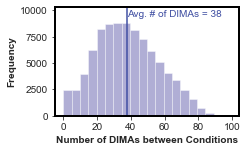

In [17]:
dima_list = df_dima.values.tolist()
dima_list = list(itertools.chain.from_iterable(dima_list))
dima_list = [x for x in dima_list if str(x) != 'nan']

from statistics import mean 
dima_mean = int(round(mean(dima_list),0))


fig, ax = plt.subplots(figsize = (3.3,2))

sns.distplot(dima_list, kde=False, bins=20, color='#3a3596')
ax.axvline(dima_mean, 0,1, color = '#3F4EA2')
ax.text(dima_mean, 9400, 'Avg. # of DIMAs = '+str(dima_mean), color='#3F4EA2')

ax.spines['top'].set_color('0'); ax.spines['bottom'].set_color('0')
ax.spines['left'].set_color('0'); ax.spines['right'].set_color('0')

ax.spines['top'].set_linewidth(2); ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2); ax.spines['right'].set_linewidth(2)
ax.set_ylim(0,10300)

ax.set_ylabel('Frequency', fontweight ='bold')
ax.set_xlabel('Number of DIMAs between Conditions', fontweight ='bold' )
plt.savefig('./fig3/dimas_histogram.pdf', dpi = 600, bbox_inches = 'tight')

In [18]:
dima_collapse = pd.melt(df_dima, ignore_index=False).dropna().reset_index().rename(columns={'index':'cond1', 'variable':'cond2', 'value':'Number of DIMAs'})
dima_collapse['cond1'] = dima_collapse['cond1'].str.replace('_',':')
dima_collapse['cond2'] = dima_collapse['cond2'].str.replace('_',':')
dima_collapse = dima_collapse[dima_collapse['cond1'] != dima_collapse['cond2']]
dima_collapse['cond1_cond2'] = dima_collapse['cond1']+"_"+dima_collapse['cond2']

dima_collapse.head()

,cond1,cond2,Number of DIMAs,cond1_cond2
1,42c:42c:ale1,42c:42c:ale10,20.0,42c:42c:ale1_42c:42c:ale10
2,42c:42c:ale1,42c:42c:ale2,41.0,42c:42c:ale1_42c:42c:ale2
3,42c:42c:ale10,42c:42c:ale2,22.0,42c:42c:ale10_42c:42c:ale2
4,42c:42c:ale1,42c:42c:ale3,40.0,42c:42c:ale1_42c:42c:ale3
5,42c:42c:ale10,42c:42c:ale3,20.0,42c:42c:ale10_42c:42c:ale3


In [19]:
degs = pd.read_csv('./data/degs_combined.csv', index_col=0)
degs_collapse = pd.melt(degs, ignore_index=False).dropna().reset_index().rename(columns={'index':'cond1', 'variable':'cond2','value':'Number of DEGs'})
degs_collapse['cond1'] = degs_collapse['cond1'].str.replace('_',':')
degs_collapse['cond2'] = degs_collapse['cond2'].str.replace('_',':')
degs_collapse = degs_collapse[degs_collapse['cond1'] != degs_collapse['cond2']]
degs_collapse['cond1_cond2'] = degs_collapse['cond1']+"_"+degs_collapse['cond1']

degs_collapse.head()

,cond1,cond2,Number of DEGs,cond1_cond2
0,control:wt:glc,fur:wt:dpd,659.0,control:wt:glc_control:wt:glc
1,control:wt:glc,fur:wt:fe,54.0,control:wt:glc_control:wt:glc
2,fur:wt:dpd,fur:wt:fe,714.0,fur:wt:dpd_fur:wt:dpd
3,control:wt:glc,fur:delfur:dpd,566.0,control:wt:glc_control:wt:glc
4,fur:wt:dpd,fur:delfur:dpd,42.0,fur:wt:dpd_fur:wt:dpd


In [20]:
degs_collapse2 = pd.melt(degs, ignore_index=False).dropna().reset_index().rename(columns={'index':'cond1', 'variable':'cond2','value':'Number of DEGs'})
degs_collapse2['cond1'] = degs_collapse2['cond1'].str.replace('_',':')
degs_collapse2['cond2'] = degs_collapse2['cond2'].str.replace('_',':')
degs_collapse2 = degs_collapse2[degs_collapse2['cond1'] != degs_collapse2['cond2']]
degs_collapse2['cond1_cond2'] = degs_collapse2['cond2']+"_"+degs_collapse2['cond1']

degs_collapse2.head()

,cond1,cond2,Number of DEGs,cond1_cond2
0,control:wt:glc,fur:wt:dpd,659.0,fur:wt:dpd_control:wt:glc
1,control:wt:glc,fur:wt:fe,54.0,fur:wt:fe_control:wt:glc
2,fur:wt:dpd,fur:wt:fe,714.0,fur:wt:fe_fur:wt:dpd
3,control:wt:glc,fur:delfur:dpd,566.0,fur:delfur:dpd_control:wt:glc
4,fur:wt:dpd,fur:delfur:dpd,42.0,fur:delfur:dpd_fur:wt:dpd


In [21]:
df_com = pd.concat([dima_collapse.merge(degs_collapse, on='cond1_cond2'), dima_collapse.merge(degs_collapse2, on='cond1_cond2')],axis=0)

df_com.head()

,cond1_x,cond2_x,Number of DIMAs,cond1_cond2,cond1_y,cond2_y,Number of DEGs
0,abx:media:camhb:cef,abx:media:camhb:ctrl,0.0,abx:media:camhb:cef_abx:media:camhb:ctrl,abx:media:camhb:ctrl,abx:media:camhb:cef,220.0
1,abx:media:camhb:cipro,abx:media:camhb:ctrl,9.0,abx:media:camhb:cipro_abx:media:camhb:ctrl,abx:media:camhb:ctrl,abx:media:camhb:cipro,352.0
2,abx:media:camhb:cef,abx:media:camhb:mero,0.0,abx:media:camhb:cef_abx:media:camhb:mero,abx:media:camhb:mero,abx:media:camhb:cef,100.0
3,abx:media:camhb:cipro,abx:media:camhb:mero,6.0,abx:media:camhb:cipro_abx:media:camhb:mero,abx:media:camhb:mero,abx:media:camhb:cipro,257.0
4,abx:media:camhb:cef,abx:media:camhb:trisulf,0.0,abx:media:camhb:cef_abx:media:camhb:trisulf,abx:media:camhb:trisulf,abx:media:camhb:cef,84.0


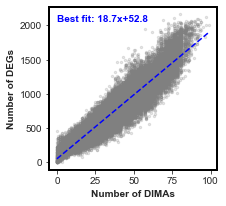

In [22]:
fig, ax = plt.subplots(figsize=(3,3))

y=df_com["Number of DEGs"]
x=df_com["Number of DIMAs"]
ax.scatter(x=x, y=y, color='gray', alpha=.2, s=6)

#best fit line
m, b = np.polyfit(x, y, 1)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
        ls = '--', color='blue')
ax.text(0,2050, 'Best fit: '+str(round(m,1))+'x+'+str(round(b,1)),
        fontweight ='bold', color='blue')

#format
ax.spines['top'].set_color('0'); ax.spines['bottom'].set_color('0')
ax.spines['left'].set_color('0'); ax.spines['right'].set_color('0')
ax.spines['top'].set_linewidth(2); ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2); ax.spines['right'].set_linewidth(2)

ax.set_xlabel('Number of DIMAs', fontweight ='bold')
ax.set_ylabel('Number of DEGs', fontweight ='bold' )
plt.savefig('./fig3/degs_versus_dima.pdf', dpi = 600, bbox_inches = 'tight')

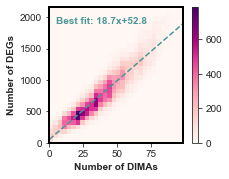

In [112]:
# heat version

fig, ax = plt.subplots(figsize=(3,2.5))

y=df_com["Number of DEGs"]
x=df_com["Number of DIMAs"]

# code from https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(30,30))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
scatterheat = ax.imshow(heatmap.T, extent=extent, origin='lower', 
                        aspect='auto', cmap='RdPu')
plt.colorbar(scatterheat)

# best fit line
m, b = np.polyfit(x, y, 1)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
        ls = '--', color='#4a9696')
ax.text(5,1900, 'Best fit: '+str(round(m,1))+'x+'+str(round(b,1)),
        fontweight ='bold', color='#4a9696')

#format
ax.spines['top'].set_color('0'); ax.spines['bottom'].set_color('0')
ax.spines['left'].set_color('0'); ax.spines['right'].set_color('0')
ax.spines['top'].set_linewidth(2); ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2); ax.spines['right'].set_linewidth(2)

ax.set_xlabel('Number of DIMAs', fontweight ='bold')
ax.set_ylabel('Number of DEGs', fontweight ='bold' )
plt.savefig('./fig3/degs_versus_dima.pdf', dpi = 600, bbox_inches = 'tight')